# ARIMA Modelling: Forecasting Weekly Hotel Cancellations

# Milestone 1

The below defines the procedures for forming the weekly time series as specified.

### Import Libraries and define dtypes

In [1]:
import csv
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pmdarima as pm
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf

from numpy.random import seed
seed(1)
from pandas import DataFrame
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.tsa.stattools as ts

dtypes = {
        'IsCanceled':                                    'float64',
        'LeadTime':                                          'float64',
        'StaysInWeekendNights':                                     'float64',
        'StaysInWeekNights':                                     'float64',
        'Adults':                            'float64',
        'Children':                            'float64',
        'Babies':                                  'float64',
        'Meal':                                    'category',
        'Country':                                               'category',
        'MarketSegment':                                    'category',
        'DistributionChannel':                                       'category',
        'IsRepeatedGuest':                               'float64',
        'PreviousCancellations':                                    'float64',
        'PreviousBookingsNotCanceled':                          'float64',
        'ReservedRoomType':                                             'category',
        'AssignedRoomType':                                            'category',
        'BookingChanges':                                                'float64',
        'DepositType':                                              'category',
        'Agent':                                              'category',
        'Company':                                 'category',
        'DaysInWaitingList':                                           'float64',
        'CustomerType':                                           'category',
        'ADR':                                          'float64',
        'RequiredCarParkingSpaces':                                      'float64',
        'TotalOfSpecialRequests':                                              'float64',
        'ReservationStatus':                                                'category'
        }

### Data is sorted by year and week number

In [2]:
train_df = pd.read_csv('H1.csv', dtype=dtypes, converters={'ArrivalDateWeekNumber': '{:0>2}'.format})
a=train_df.head()
b=train_df
b
c=b.sort_values(['ArrivalDateYear','ArrivalDateWeekNumber'], ascending=True)
c=pd.DataFrame(c)
c
type(c)

pandas.core.frame.DataFrame

In [3]:
c

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
0,0.0,342.0,2015,July,27,1,0.0,0.0,2.0,0.0,...,No Deposit,NULL,NULL,0.0,Transient,0.00,0.0,0.0,Check-Out,2015-07-01
1,0.0,737.0,2015,July,27,1,0.0,0.0,2.0,0.0,...,No Deposit,NULL,NULL,0.0,Transient,0.00,0.0,0.0,Check-Out,2015-07-01
2,0.0,7.0,2015,July,27,1,0.0,1.0,1.0,0.0,...,No Deposit,NULL,NULL,0.0,Transient,75.00,0.0,0.0,Check-Out,2015-07-02
3,0.0,13.0,2015,July,27,1,0.0,1.0,1.0,0.0,...,No Deposit,304,NULL,0.0,Transient,75.00,0.0,0.0,Check-Out,2015-07-02
4,0.0,14.0,2015,July,27,1,0.0,2.0,2.0,0.0,...,No Deposit,240,NULL,0.0,Transient,98.00,0.0,1.0,Check-Out,2015-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40055,0.0,212.0,2017,August,35,31,2.0,8.0,2.0,1.0,...,No Deposit,143,NULL,0.0,Transient,89.75,0.0,0.0,Check-Out,2017-09-10
40056,0.0,169.0,2017,August,35,30,2.0,9.0,2.0,0.0,...,No Deposit,250,NULL,0.0,Transient-Party,202.27,0.0,1.0,Check-Out,2017-09-10
40057,0.0,204.0,2017,August,35,29,4.0,10.0,2.0,0.0,...,No Deposit,250,NULL,0.0,Transient,153.57,0.0,3.0,Check-Out,2017-09-12
40058,0.0,211.0,2017,August,35,31,4.0,10.0,2.0,0.0,...,No Deposit,40,NULL,0.0,Contract,112.80,0.0,1.0,Check-Out,2017-09-14


In [4]:
df = DataFrame(c, columns= ['ArrivalDateYear', 'ArrivalDateWeekNumber']) 
df

,ArrivalDateYear,ArrivalDateWeekNumber
0,2015,27
1,2015,27
2,2015,27
3,2015,27
4,2015,27
...,...,...
40055,2017,35
40056,2017,35
40057,2017,35
40058,2017,35


In [5]:
df1 = df['ArrivalDateYear'].map(str) + df['ArrivalDateWeekNumber'].map(str)
print (df1)
df1=pd.DataFrame(df1)

0        201527
1        201527
2        201527
3        201527
4        201527
          ...  
40055    201735
40056    201735
40057    201735
40058    201735
40059    201735
Length: 40060, dtype: object


### Cancellation entries are joined with the associated date

In [6]:
df2 = DataFrame(c, columns= ['IsCanceled']) 
df2

,IsCanceled
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
40055,0.0
40056,0.0
40057,0.0
40058,0.0


In [7]:
type(df1)

pandas.core.frame.DataFrame

In [8]:
df3=pd.concat([df1, df2], axis = 1)
df3
df3.columns = ['FullDate', 'IsCanceled']

In [9]:
df3
df3.sort_values(['FullDate','IsCanceled'], ascending=True)

,FullDate,IsCanceled
0,201527,0.0
1,201527,0.0
2,201527,0.0
3,201527,0.0
4,201527,0.0
...,...,...
13799,201735,1.0
13800,201735,1.0
13801,201735,1.0
13802,201735,1.0


### Cancellations are aggregated on a weekly basis

In [10]:
df4 = df3.groupby('FullDate').agg(sum)
df4
df4.sort_values(['FullDate'], ascending=True)

,IsCanceled
FullDate,
201527,41.0
201528,48.0
201529,87.0
201530,74.0
201531,101.0
...,...
201731,173.0
201732,140.0
201733,182.0


In [11]:
tseries=df4['IsCanceled']
tseries

FullDate
201527     41.0
201528     48.0
201529     87.0
201530     74.0
201531    101.0
          ...  
201731    173.0
201732    140.0
201733    182.0
201734    143.0
201735    100.0
Name: IsCanceled, Length: 115, dtype: float64

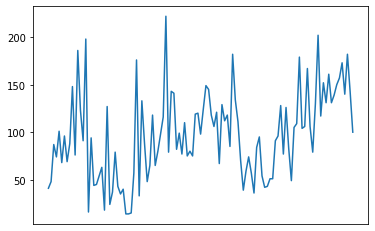

In [12]:
plt.plot(tseries)
plt.tick_params(
    axis='x',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False)
plt.show()

Note the components of each time series as graphed below. This provides important visual signals for the structure of the time series, and is important for a more intuitive understanding of the eventual ARIMA model structure that will be chosen.